In [33]:
import pickle
import numpy as np

# get question to experiment with
generations = pickle.load(open('./data/openai_temp=1.0_reasoning=False_generations.pkl', 'rb'))
semsim = pickle.load(open('./data/openai_gpt_reas=False_temp=1.0_semantic_similarity.pkl', 'rb'))

def is_n_clusters(d, n=4):
    return len(np.unique(list(d.values()))) == n

subset = [key for key, value in semsim.items() if is_n_clusters(value)]
question = [qn for qn in generations if qn["id"] == subset[-4]][0]
entailments = semsim[subset[-4]]


In [34]:
question["question"]

'Significant pruritus in a 52-year-old smoker with red plaques and some warty lesions. What is the most appropriate management in this scenario?'

In [35]:
question["generated_answers"]

['Perform a skin biopsy for diagnosis.',
 'Perform a biopsy of the lesions.',
 'Topical corticosteroids.',
 'Topical corticosteroids and smoking cessation advice are appropriate management steps.',
 'Perform a biopsy to determine the exact diagnosis.',
 'Skin biopsy to confirm diagnosis; consider referral to a dermatologist.',
 'Topical corticosteroids and vitamin D analogues.',
 'Perform a biopsy to confirm diagnosis.',
 'Consider topical treatment like 5-fluorouracil or imiquimod cream.',
 'Biopsy the lesions for histopathological diagnosis.']

In [41]:
from entailment import get_oneshot_gpt_entailment

entailments = get_oneshot_gpt_entailment(question["question"], question["generated_answers"])

straight up clusters=[Cluster(cluster=[AnswerIndex(index=0), AnswerIndex(index=1), AnswerIndex(index=4), AnswerIndex(index=5), AnswerIndex(index=7), AnswerIndex(index=9)]), Cluster(cluster=[AnswerIndex(index=2), AnswerIndex(index=3), AnswerIndex(index=6)]), Cluster(cluster=[AnswerIndex(index=8)])]


In [47]:
# construct a graph based on the original entailment
import networkx as nx
G = nx.Graph()

for idx, ans in enumerate(question["generated_answers"]):
    G.add_node(idx)

for idx, ans in enumerate(question["generated_answers"]):
    group1 = entailments[idx]
    print(idx, ans, group1)
    for jdx, group2 in entailments.items():
        if jdx != idx:
            if group1 == group2:
                G.add_edge(idx, jdx)

0 Perform a skin biopsy for diagnosis. 0
1 Perform a biopsy of the lesions. 0
2 Topical corticosteroids. 1
3 Topical corticosteroids and smoking cessation advice are appropriate management steps. 1
4 Perform a biopsy to determine the exact diagnosis. 0
5 Skin biopsy to confirm diagnosis; consider referral to a dermatologist. 0
6 Topical corticosteroids and vitamin D analogues. 1
7 Perform a biopsy to confirm diagnosis. 0
8 Consider topical treatment like 5-fluorouracil or imiquimod cream. 2
9 Biopsy the lesions for histopathological diagnosis. 0


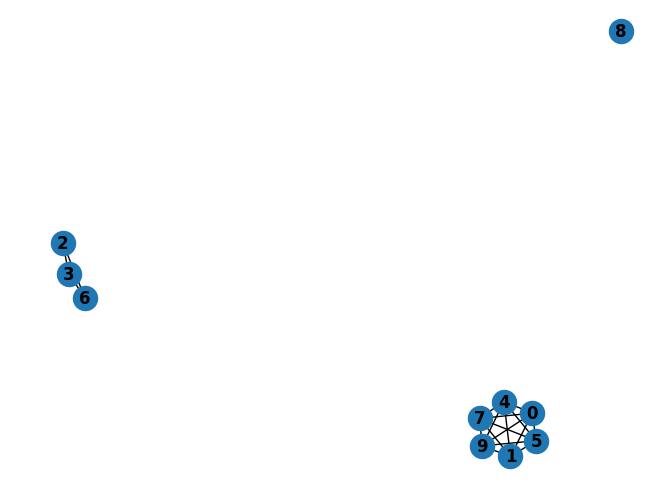

In [48]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True, font_weight='bold')

In [49]:
from entailment import get_gpt_entailment
def process_sequence(s):
        print("id ", s['id'], "gpt")
        question = s["question"]
        answers = s["generated_answers"]
        # base semantic set 
        semantic_set_ids = {}
        for idx, answer in enumerate(answers):
            # initialize with a bad answer
            semantic_set_ids[idx] = -1

        # Keep track of current id.
        next_id = 0
        for i, string1 in enumerate(answers):
            # this inner loop compared each gen ans with other answers

            # Check if string1 already has an id assigned.
            if semantic_set_ids[i] == -1:
                semantic_set_ids[i] = next_id
                # If string1 has not been assigned an id, assign it next_id.
                for j in range(i + 1, len(answers)):
                    entailed = get_gpt_entailment(
                            question,
                            string1,
                            answers[j],
                            strict=True
                            )
                    if entailed:
                        semantic_set_ids[j] = semantic_set_ids[i]
                next_id += 1

        return (s['id'], semantic_set_ids)

_, entailments = process_sequence(question)

id  1796 gpt


In [50]:
# construct a graph based on the original entailment
import networkx as nx
G = nx.Graph()

for idx, ans in enumerate(question["generated_answers"]):
    G.add_node(idx)

for idx, ans in enumerate(question["generated_answers"]):
    group1 = entailments[idx]
    print(idx, ans, group1)
    for jdx, group2 in entailments.items():
        if jdx != idx:
            if group1 == group2:
                G.add_edge(idx, jdx)

0 Perform a skin biopsy for diagnosis. 0
1 Perform a biopsy of the lesions. 0
2 Topical corticosteroids. 1
3 Topical corticosteroids and smoking cessation advice are appropriate management steps. 2
4 Perform a biopsy to determine the exact diagnosis. 0
5 Skin biopsy to confirm diagnosis; consider referral to a dermatologist. 3
6 Topical corticosteroids and vitamin D analogues. 4
7 Perform a biopsy to confirm diagnosis. 3
8 Consider topical treatment like 5-fluorouracil or imiquimod cream. 5
9 Biopsy the lesions for histopathological diagnosis. 3


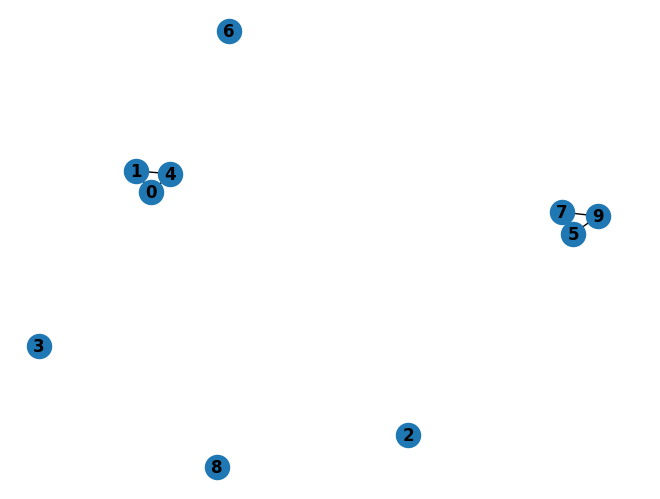

In [51]:
nx.draw(G, with_labels=True, font_weight='bold')